In [1]:
import numpy as np
from shapely import Polygon, LineString
from shapely.ops import unary_union
import utm
import ast

### Helper functions

In [2]:
def from_latlon(latitude, longitude, geozone_num, geozone_let):
    """
    convert lat, lon to (x, y) coordinates (in meters)
    :param latitude:  list or np.array (shape: (n,))
    :param longitude: list or np.array (shape: (n,))
    :param geozone_num: geozone integer
    :param geozone_let: geozone letter
    :return: np.array of (x, y) coordinates (shape: (n, 2))
    """
    xy = np.array([
        utm.from_latlon(
            latitude=lat, 
            longitude=lon, 
            force_zone_number=geozone_num,
            force_zone_letter=geozone_let
        )[:2] for lat, lon in zip(latitude, longitude)
    ])
    return xy



def get_subfields_xy(field_bounds: list, geozone_num, geozone_let):
    """
    convert GPS bounds of field into (x, y) coordinates (in meters)
    :param field_bounds: list with GPS bounds of subfields
    :return: list of (x, y) bounds of the subfields
    """
    subfields = [np.array(subfield).T for subfield in field_bounds]
    bounds_xy = [from_latlon(field[1], field[0], geozone_num, geozone_let) for field in subfields]
    return bounds_xy



def get_bounds_from_string(field_bounds_str : str):
    """
    convert string representation of the bounds into list
    :param field_bounds_str: string representation of the bounds
    :return: list of bounds of the subfields
    """
    if field_bounds_str[:4] == '[[[[':
        field_bounds_str = field_bounds_str.replace('[[[', '[[').replace(']]]', ']]')
    field_bounds = ast.literal_eval(field_bounds_str) 
    return field_bounds



def get_geozone(latitude, longitude):
    """
    :param latitude: 
    :param longitude: 
    :return: UTM geozone number and letter
    """
    geozone_num, geozone_let = utm.from_latlon(latitude, longitude)[2:]
    return geozone_num, geozone_let

### Main function to compute area and distance

In [3]:
def get_area_and_distance(
    tool_width : float,
    time : list,
    track_lat : list,
    track_lon : list,
    path_distance : list,
    field_processed : list,
    field_bounds : str
):
    # get working UTM zone number and letter (they define the reference frame of conversion)
    geozone_num, geozone_let = get_geozone(track_lat[0], track_lon[0])
    
    # convert GPS coordinates of the track to (X, Y) system (in meters)
    track_xy = from_latlon(track_lat, track_lon, geozone_num, geozone_let)
    
    # convert GPS coordinates of the field bounds (in meters)
    subfields_xy = get_subfields_xy(field_bounds, geozone_num, geozone_let)
    # create field polygon as the union of subfields
    field_polygon = unary_union([
        Polygon(subfield).buffer(0) if len(subfield) > 1 else None for subfield in subfields_xy
    ])
    
    # get the length of preprocessed track
    processed_idx = len(field_processed)
    # compute preprocessed track and intersect it with the field polygon
    computed_track = LineString(track_xy[:processed_idx + 1]) \
                    .buffer(tool_width/2, cap_style='flat') \
                    .intersection(field_polygon)

    # calculation loop : for two consecutive track points (i, i+1)
    for i in range(processed_idx, len(time)):
        # create LineString object as a subtrack
        subtrack = LineString(track_xy[i-1:i+1])
        # compute distance between these points, and add new cumulative distance to the list
        path_distance.append(path_distance[-1] + subtrack.length)

        # add buffer to the subtrack, and intersect it with the field polygon
        subfield = subtrack.buffer(tool_width/2) \
                           .intersection(field_polygon) 
        # add this intersection to the preprocessed track
        computed_track = computed_track.union(subfield)
        # add new cumulative area to the list
        field_processed.append(computed_track.area)
        
    # create dictionary with the output
    area_calc = {
        'tool_width': tool_width,
        'time': time,
        'lat': track_lat,
        'long': track_lon,
        'path_distance': path_distance,
        'field_processed': field_processed
    }

    return area_calc

### Function to update area-calculation state

In [4]:
def update_area_calc(area_calc : dict, field_bounds_str : str):
    """
    update area_calc state 
    :param area_calc: dictionary of the field processing state
    :param field_bounds_str: string representation of the bounds
    :return: updated dictionary of the field processing state 
    
    """
    field_bounds = get_bounds_from_string(field_bounds_str)
    area_calc = get_area_and_distance(
        tool_width=area_calc['tool_width'],
        time=area_calc['time'],
        track_lat=area_calc['lat'],
        track_lon=area_calc['long'],
        path_distance=area_calc['path_distance'],
        field_processed=area_calc['field_processed'],
        field_bounds=field_bounds
    )
    return area_calc

### Test

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('../fields100.csv')
field_bounds_str = df.iloc[0]['geometry_coordinates']
field_bounds_str[:30]

'[[[23.999951022,50.067867025,-'

In [7]:
# helper function to get polygon
def get_polygon(string_coords):
    field_bounds = get_bounds_from_string(string_coords)
    zone_num, zone_let = get_geozone(field_bounds[0][0][1], field_bounds[0][0][0])
    subfields_xy = get_subfields_xy(field_bounds, zone_num, zone_let)
    return unary_union([Polygon(subfield).buffer(0) if len(subfield) > 1 else None for subfield in subfields_xy])

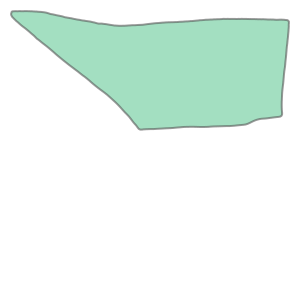

In [8]:
get_polygon(field_bounds_str)

In [9]:
start_point = np.array([23.990487, 50.063754])
diff = np.random.uniform(-0.00500, 0.011000, (1000, 2))/500
diff.min(), diff.max()

(-9.991880490697784e-06, 2.195062810777175e-05)

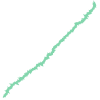

In [10]:
path = [start_point]
for dxy in diff:
    path.append(path[-1] + dxy)
path = np.array(path)
lpath = LineString(path)
lpath

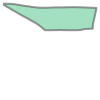

In [11]:
Polygon(get_bounds_from_string(field_bounds_str)[0])

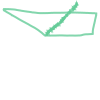

In [12]:
lpath.union(LineString(get_bounds_from_string(field_bounds_str)[0]))

# Time test of each step

### Parameters

In [13]:
# parameters
track_len = 300

tool_width = 8
time = np.ones(track_len)
track_lon, track_lat = path[:track_len].T
path_distance = [0]
field_processed = [0]

### 1. Get polygon bounds from string

In [14]:
%%time
field_bounds = get_bounds_from_string(field_bounds_str)

CPU times: user 17.3 ms, sys: 621 µs, total: 17.9 ms
Wall time: 17.8 ms


### 2. Get UTM geozone number and letter

In [15]:
%%time
geozone_num, geozone_let = get_geozone(track_lat[0], track_lon[0])

CPU times: user 301 µs, sys: 4 µs, total: 305 µs
Wall time: 310 µs


### 3. Convert track (Lat, Lon) to (X, Y)

In [16]:
%%time
track_xy = from_latlon(track_lat, track_lon, geozone_num, geozone_let)

CPU times: user 37 ms, sys: 1.85 ms, total: 38.8 ms
Wall time: 37.6 ms


### 4. Convert field (Lat, Lon) bounds to (X, Y)

In [17]:
%%time
subfields_xy = get_subfields_xy(field_bounds, geozone_num, geozone_let)

CPU times: user 64.8 ms, sys: 1.87 ms, total: 66.7 ms
Wall time: 65.5 ms


### 5. Get create field polygon

In [18]:
%%time
field_polygon = unary_union([
    Polygon(subfield).buffer(0) if len(subfield) > 1 else None for subfield in subfields_xy
])

CPU times: user 2.3 ms, sys: 1.2 ms, total: 3.51 ms
Wall time: 2.09 ms


### 6. Calculate path distances and processed area for each subpath

In [19]:
%%time
# get the length of preprocessed track
processed_idx = len(field_processed)
# compute preprocessed track and intersect it with the field polygon
computed_track = LineString(track_xy[:processed_idx + 1]) \
                .buffer(tool_width/2, cap_style='flat') \
                .intersection(field_polygon)

# calculation loop : for two consecutive track points (i, i+1)
for i in range(processed_idx, len(time)):
    # create LineString object as a subtrack
    subtrack = LineString(track_xy[i-1:i+1])
    # compute distance between these points, and add new cumulative distance to the list
    path_distance.append(path_distance[-1] + subtrack.length)

    # add buffer to the subtrack, and intersect it with the field polygon
    subfield = subtrack.buffer(tool_width/2) \
                       .intersection(field_polygon) 
    # add this intersection to the preprocessed track
    computed_track = computed_track.union(subfield)
    # add new cumulative area to the list
    field_processed.append(computed_track.area)

CPU times: user 170 ms, sys: 3.13 ms, total: 173 ms
Wall time: 171 ms


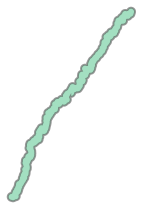

In [20]:
computed_track

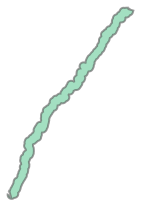

In [21]:
prev_track = LineString(track_xy) \
            .buffer(tool_width/2, cap_style='flat') \
            .intersection(field_polygon)
prev_track

In [22]:
computed_track.area, prev_track.area

(2223.2417650744856, 2180.7159349630174)

### Total new time

In [23]:
track_len = 300

tool_width = 8
time = np.ones(track_len)
track_lon, track_lat = path[:track_len].T
path_distance = [0]
field_processed = [0]

In [24]:
%%time
res = get_area_and_distance(
    tool_width=tool_width,
    time=time,
    track_lat=track_lat,
    track_lon=track_lon,
    path_distance=path_distance,
    field_processed=field_processed,
    field_bounds=get_bounds_from_string(field_bounds_str)
)

CPU times: user 234 ms, sys: 4.05 ms, total: 238 ms
Wall time: 237 ms
